<a href="https://colab.research.google.com/github/ronak-2004/Advanced-Problem-Solving/blob/main/phase_coding_audio_stegan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Audio Steganography — Phase Encoding
This notebook implements **encoding** (phase encoding) and **decoding** for hiding text inside a `.wav` audio file.
- The encode function is the original code you provided (kept functionally intact).
- The decode function extracts the hidden message from the encoded audio.
**Assumption:** the encoder pads the message to 100 characters (using `~`) before encoding.


In [16]:
# install/imports
import os
import numpy as np
from scipy.io import wavfile
import matplotlib.pyplot as plt

In [17]:
import numpy as np
from scipy.io.wavfile import write

rate = 44100  # Sampling rate
duration = 2  # seconds
freq = 440    # Hz
t = np.linspace(0, duration, int(rate*duration), endpoint=False)
signal = 0.5 * np.sin(2 * np.pi * freq * t)

write("input.wav", rate, (signal * 32767).astype(np.int16))


## Step 1 — Encode (segmentation + FFT)
 `encode()` function:

1. **Read the Audio File**  
   - The input audio file is read using `wavfile.read(audioLocation)`.  
   - The sampling rate (`rate`) and raw audio data (`audioData`) are extracted.  
   - If stereo audio is detected, only one channel is used for embedding.

2. **Prepare the Secret Message**  
   - The input text message is converted to binary representation.  
   - Each character in the message is represented as **8 bits** (ASCII values).  
   - A special padding character (e.g., `"~"`) may be added to indicate message end.

3. **Define Block Parameters**  
   - `textLength` specifies how many bits of the message will be embedded in a block.  
   - `blockLength` is computed as the smallest power of two greater than twice the `textLength` (needed for FFT operations).  
   - `blockMid` is the midpoint of the FFT output, which corresponds to the **central frequency bin**.

4. **Extract the Target Block**  
   - The first `blockLength` samples from the audio are selected.  
   - These samples will hold the hidden message without significantly altering the overall audio.

5. **Fourier Transform**  
   - The Fast Fourier Transform (FFT) is applied to the block to obtain frequency-domain data.  
   - This produces an array of **complex numbers** representing magnitude and phase of each frequency component.

6. **Embed the Binary Message in Phase Data**  
   - The central portion of the FFT phase spectrum (from `blockMid - textLength` to `blockMid`) is selected for embedding.  
   - Positive phase values are replaced to represent binary `0`, and negative phase values to represent binary `1` (or vice versa).  
   - This step changes **only the phase**, not the magnitude, minimizing perceptual distortion.

7. **Inverse FFT and Reconstruction**  
   - The modified frequency-domain block is transformed back to time domain using the inverse FFT (`ifft`).  
   - The altered block replaces the original samples in the audio data.  
   - The rest of the audio remains untouched.

8. **Save the Stego-Audio**  
   - The modified audio is saved as a `.wav` file.  
   - This new audio file now carries the hidden message, which can be later extracted with the decoding function.



In [18]:
def encode(pathToAudio, stringToEncode):
    """
    Encodes a given string into an audio file using Phase Encoding.
    Returns path to output encoded wav.
    """
    rate, audioData1 = wavfile.read(pathToAudio)
    stringToEncode = stringToEncode.ljust(100, '~')  # Pad message to fixed length
    textLength = 8 * len(stringToEncode)  # Total number of bits
    chunkSize = int(2 * 2 ** np.ceil(np.log2(2 * textLength)))
    numberOfChunks = int(np.ceil(audioData1.shape[0] / chunkSize))
    audioData = audioData1.copy()

    # Breaking the Audio into chunks
    if len(audioData1.shape) == 1:
        audioData.resize(numberOfChunks * chunkSize, refcheck=False)
        audioData = audioData[np.newaxis]
    else:
        audioData.resize((numberOfChunks * chunkSize, audioData.shape[1]), refcheck=False)
        audioData = audioData.T

    chunks = audioData[0].reshape((numberOfChunks, chunkSize))

    # Applying DFT on audio chunks
    chunks = np.fft.fft(chunks)
    magnitudes = np.abs(chunks)
    phases = np.angle(chunks)
    phaseDiff = np.diff(phases, axis=0)

    # Step 2: Convert message into binary and phase shift
    textInBinary = np.ravel([[int(y) for y in format(ord(x), "08b")] for x in stringToEncode])
    textInPi = textInBinary.copy()
    textInPi[textInPi == 0] = -1
    textInPi = textInPi * -np.pi / 2

    # Step 3: Modify the phase and apply inverse Fourier Transform
    midChunk = chunkSize // 2
    phases[0, midChunk - textLength: midChunk] = textInPi
    phases[0, midChunk + 1: midChunk + 1 + textLength] = -textInPi[::-1]

    for i in range(1, len(phases)):
        phases[i] = phases[i - 1] + phaseDiff[i - 1]

    chunks = (magnitudes * np.exp(1j * phases))
    chunks = np.fft.ifft(chunks).real

    # Step 4: Combine chunks and save encoded audio
    audioData[0] = chunks.ravel().astype(np.int16)
    dir = os.path.dirname(pathToAudio)
    output_path = os.path.join(dir, "output.wav")
    wavfile.write(output_path, rate, audioData.T)

    return output_path


## Step 2 — Decode
`decode()` function:

1. **Read the Encoded Audio File**  
   - The audio is read using `wavfile.read()` to obtain both the sample rate and the audio data array.  
   - We know the original message length was fixed (padded), so `textLength` is set accordingly.

2. **Determine Block Size**  
   - The block length is computed as the next power-of-two length that can contain the entire message.  
   - `blockMid` marks the midpoint of the FFT block, where the encoded phase information is stored.

3. **Extract First Block of Audio**  
   - The first block of samples (size = `blockLength`) is extracted from the audio file.  
   - If the file is stereo, only the first channel is used.

4. **Obtain Phase Values from the First Block**  
   - The **Fourier Transform (FFT)** is applied to the block to get complex frequency components.  
   - `np.angle()` extracts the phase values.  
   - Only the range containing the message (`blockMid - textLength : blockMid`) is considered.

5. **Convert Phases to Binary Data**  
   - Since encoding used `+π/2` for bit `0` and `-π/2` for bit `1`, checking if a phase value is negative allows recovery of the bit.  
   - This results in a binary array (`0` or `1` values).

6. **Reconstruct Characters from Binary**  
   - Binary bits are grouped in chunks of 8 (one byte per character).  
   - Each byte is converted to its ASCII code using dot product with powers of 2.  
   - The ASCII codes are then converted to characters.

7. **Remove Padding Characters**  
   - Any trailing `~` characters (used during encoding to pad the message length) are removed.  
   - The final string is returned as the decoded secret message.



In [19]:
def decode(audioLocation):
    rate, audioData = wavfile.read(audioLocation)
    print(rate)
    textLength = 800
    blockLength = 2 * int(2 ** np.ceil(np.log2(2 * textLength)))
    blockMid = blockLength // 2
    print(blockLength, blockMid)
    # Get header info
    if len(audioData.shape) == 1:
        code = audioData[:blockLength]
    else:
        code = audioData[:blockLength, 0]
    print(code)
    # Get the phase and convert it to binary
    codePhases = np.angle(np.fft.fft(code))[blockMid - textLength:blockMid]
    codeInBinary = (codePhases < 0).astype(np.int16)

    # Convert into characters
    codeInIntCode = codeInBinary.reshape((-1, 8)).dot(1 << np.arange(8 - 1, -1, -1))

    # Combine characters to original text
    return "".join(np.char.mod("%c", codeInIntCode)).replace("~", "")

#Step 3 — Demonstration and Execution


In [20]:
# =============================
# DEMO: Audio Steganography
# =============================

# Path to your input WAV file
input_audio_path = "input.wav"   # <-- replace with your actual WAV file path

# Secret message to hide
secret_message = input("Enter Message :")

# Step 1: Encode the message into the audio
print("Encoding message into audio...")
encoded_audio_path = encode(input_audio_path, secret_message)
print(f"Encoded audio saved at: {encoded_audio_path}")

# Step 2: Decode the message from the encoded audio
print("\nDecoding message from audio...")
decoded_message = decode(encoded_audio_path)
print(f"Decoded message: '{decoded_message}'")

Enter Message :Hello I am SpiderMan
Encoding message into audio...
Encoded audio saved at: output.wav

Decoding message from audio...
44100
4096 2048
[ -2334   2638   1468 ... -14697 -14049 -10839]
Decoded message: 'Hello I am SpiderMan'


## Step 3.1 — Visualize Audio Phase

The `visualize_audio_phase()` function compares the **phase spectra** of the original input audio and the encoded output audio to analyze changes caused by the steganography process.

### How It Works
1. **Read Audio Files**  
   - Uses `scipy.io.wavfile.read()` to load the WAV files.  
   - If the audio is stereo, only the **first channel** is used for analysis.

2. **FFT for Phase Analysis**  
   - Computes the **Fast Fourier Transform (FFT)** of both signals.  
   - Extracts the **phase angles** from the FFT using `np.angle()`.

3. **Plot Phase Spectra**  
   - Creates two subplots:
     - **Top:** Phase spectrum of the original input audio.
     - **Bottom:** Phase spectrum of the output (encoded) audio.
   - Each plot shows **frequency bins** on the X-axis and **phase in radians** on the Y-axis.

### Purpose
By visualizing the phase spectra before and after encoding, we can:
- Detect **phase shifts** introduced by message embedding.
- Evaluate if the steganography method significantly alters the audio's phase characteristics, which might be detectable by steganalysis.


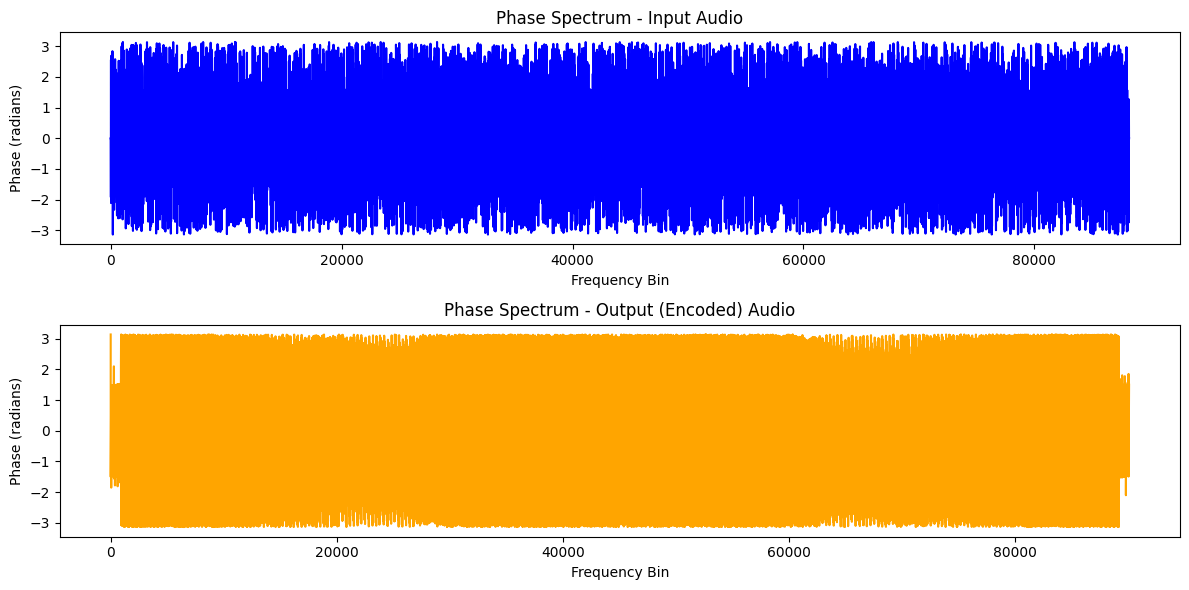

In [21]:
# Step 3.1: Visualization
def visualize_audio_phase(input_path, output_path):
    # Read input audio
    rate_in, data_in = wavfile.read(input_path)
    if data_in.ndim > 1:
        data_in = data_in[:, 0]  # Take only first channel

    # Read output audio
    rate_out, data_out = wavfile.read(output_path)
    if data_out.ndim > 1:
        data_out = data_out[:, 0]

    # FFT for phase analysis
    phase_in = np.angle(np.fft.fft(data_in))
    phase_out = np.angle(np.fft.fft(data_out))

    # Plot
    plt.figure(figsize=(12, 6))

    plt.subplot(2, 1, 1)
    plt.plot(phase_in, color='blue')
    plt.title("Phase Spectrum - Input Audio")
    plt.xlabel("Frequency Bin")
    plt.ylabel("Phase (radians)")

    plt.subplot(2, 1, 2)
    plt.plot(phase_out, color='orange')
    plt.title("Phase Spectrum - Output (Encoded) Audio")
    plt.xlabel("Frequency Bin")
    plt.ylabel("Phase (radians)")

    plt.tight_layout()
    plt.show()

visualize_audio_phase("input.wav", "output.wav")

### Step 3.2 — Verification

In this step, we verify that the decoded message exactly matches the original secret message we embedded into the audio.  
If the extraction process is correct and no data corruption has occurred, both strings will be identical.  

**Expected Output:**
-  **Success!** if the decoded message matches the original.
-  **Warning!** if there’s any mismatch, indicating potential errors in encoding/decoding or audio alteration.


In [22]:
# Step 3.2: Verification
if decoded_message == secret_message:
    print("\n Success! The decoded message matches the original.")
else:
    print("\n Warning! The decoded message does NOT match the original.")


 Success! The decoded message matches the original.
